In [ ]:
import pandas as pd
import numpy as np
import math
import time
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve, auc

from scipy.optimize import nnls

# ----------------------------
# FILE PATHS ex: /content/sample_data/hybrid_predictions.csv
# ----------------------------
#SARIMA_CSV = "sarima_forecasts.csv"
SARIMA_CSV = "../../saved_model_outputs/sarima_outputs/sarima_forecasts.csv"
LSTM_CSV   = "../../saved_model_outputs/lstm_outputs/lstm_predictions.csv"
HYBRID_CSV = "../../saved_model_outputs/hybrid_outputs/hybrid_predictions.csv"

OUT_DIR = Path("../../saved_model_outputs/ensemble_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

# ----------------------------
# METRICS HELPERS
# ----------------------------
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def wape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + eps)

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ae = np.abs(y_true - y_pred)

    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "WAPE": wape(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "AE_P50": np.percentile(ae, 50),
        "AE_P90": np.percentile(ae, 90),
        "AE_P95": np.percentile(ae, 95),
    }

print(" Setup done. OUT_DIR =", OUT_DIR.resolve())


 Setup done. OUT_DIR = /content/sample_data/ensemble_outputs


In [ ]:
sarima = pd.read_csv(SARIMA_CSV)
lstm   = pd.read_csv(LSTM_CSV)
hybrid = pd.read_csv(HYBRID_CSV)

# Debug: Print column names to understand structure
print("SARIMA columns:", sarima.columns.tolist())
print("LSTM columns:", lstm.columns.tolist())
print("Hybrid columns:", hybrid.columns.tolist())

# --- Normalize SARIMA columns ('Unnamed: 0' for date, 'forecast' for pred)
# Check if 'Unnamed: 0' exists, otherwise check for 'date' or index
if "Unnamed: 0" in sarima.columns:
    sarima = sarima.rename(columns={"Unnamed: 0": "date", "forecast": "sarima_pred"})
elif "date" not in sarima.columns and sarima.index.name is None:
    # If no date column and no index name, try first column
    first_col = sarima.columns[0]
    if sarima[first_col].dtype == 'object' or 'date' in first_col.lower() or 'time' in first_col.lower():
        sarima = sarima.rename(columns={first_col: "date"})
    if "forecast" in sarima.columns:
        sarima = sarima.rename(columns={"forecast": "sarima_pred"})
elif "date" not in sarima.columns:
    # Try to use index if it's datetime
    sarima.reset_index(inplace=True)
    if sarima.columns[0] not in ["date", "actual", "forecast", "sarima_pred"]:
        sarima = sarima.rename(columns={sarima.columns[0]: "date"})
    if "forecast" in sarima.columns:
        sarima = sarima.rename(columns={"forecast": "sarima_pred"})

# Rename prediction columns
if "predicted" in lstm.columns:
    lstm = lstm.rename(columns={"predicted": "lstm_pred"})
if "predicted" in hybrid.columns:
    hybrid = hybrid.rename(columns={"predicted": "hybrid_pred"})

# Ensure 'date' column exists for all dataframes
if "date" not in lstm.columns:
    # Try to find date-like column
    date_cols = [col for col in lstm.columns if 'date' in col.lower() or 'time' in col.lower() or 'timestamp' in col.lower()]
    if date_cols:
        lstm = lstm.rename(columns={date_cols[0]: "date"})
    elif isinstance(lstm.index, pd.DatetimeIndex):
        lstm = lstm.reset_index()
        if lstm.columns[0] not in ["date", "actual"]:
            lstm = lstm.rename(columns={lstm.columns[0]: "date"})
    else:
        raise ValueError(f"Could not find 'date' column in lstm dataframe. Columns: {lstm.columns.tolist()}")

if "date" not in hybrid.columns:
    # Try to find date-like column
    date_cols = [col for col in hybrid.columns if 'date' in col.lower() or 'time' in col.lower() or 'timestamp' in col.lower()]
    if date_cols:
        hybrid = hybrid.rename(columns={date_cols[0]: "date"})
    elif isinstance(hybrid.index, pd.DatetimeIndex):
        hybrid = hybrid.reset_index()
        if hybrid.columns[0] not in ["date", "actual"]:
            hybrid = hybrid.rename(columns={hybrid.columns[0]: "date"})
    else:
        raise ValueError(f"Could not find 'date' column in hybrid dataframe. Columns: {hybrid.columns.tolist()}")

# Parse dates (timezone-aware strings)
for df_ in (sarima, lstm, hybrid):
    if "date" in df_.columns:
        df_["date"] = pd.to_datetime(df_["date"], utc=True, errors="coerce")
        df_.dropna(subset=["date"], inplace=True)

# Select and standardize columns
if "sarima_pred" in sarima.columns:
    sarima = sarima[["date", "actual", "sarima_pred"]].copy()
else:
    # Fallback: use any prediction column
    pred_col = [col for col in sarima.columns if 'pred' in col.lower() or 'forecast' in col.lower()][0]
    sarima = sarima.rename(columns={pred_col: "sarima_pred"})
    sarima = sarima[["date", "actual", "sarima_pred"]].copy()

if "lstm_pred" in lstm.columns:
    lstm = lstm[["date", "actual", "lstm_pred"]].copy()
else:
    pred_col = [col for col in lstm.columns if 'pred' in col.lower()][0]
    lstm = lstm.rename(columns={pred_col: "lstm_pred"})
    lstm = lstm[["date", "actual", "lstm_pred"]].copy()

if "hybrid_pred" in hybrid.columns:
    hybrid = hybrid[["date", "actual", "hybrid_pred"]].copy()
else:
    pred_col = [col for col in hybrid.columns if 'pred' in col.lower()][0]
    hybrid = hybrid.rename(columns={pred_col: "hybrid_pred"})
    hybrid = hybrid[["date", "actual", "hybrid_pred"]].copy()

print("sarima:", sarima.shape, "| lstm:", lstm.shape, "| hybrid:", hybrid.shape)
#sarima.head(2)
#lstm.head(2)
hybrid.head(2)

SARIMA columns: ['utc_timestamp', 'actual', 'forecast', 'error', 'lower_ci', 'upper_ci']
LSTM columns: ['date', 'actual', 'predicted', 'error', 'abs_error', 'is_peak']
Hybrid columns: ['date', 'actual', 'predicted', 'sarima_pred', 'resid_pred', 'error', 'abs_error', 'is_peak']
sarima: (6552, 3) | lstm: (6528, 3) | hybrid: (6528, 3)


,date,actual,hybrid_pred
0,2018-01-02 00:00:00+00:00,39033.0,41904.678823
1,2018-01-02 01:00:00+00:00,38421.0,40993.073731


In [ ]:
# Merge on common timestamps
df = lstm.merge(hybrid, on="date", how="inner", suffixes=("_lstm", "_hyb"))
df = df.merge(sarima, on="date", how="inner")


max_diff = np.nanmax([
    (df["actual_lstm"] - df["actual_hyb"]).abs().max(),
    (df["actual_lstm"] - df["actual"]).abs().max(),
    (df["actual_hyb"] - df["actual"]).abs().max(),
])
print("Max actual mismatch across sources:", float(max_diff))

# Choose canonical actual (LSTM actual is fine since mismatch=0)
df["actual"] = df["actual_lstm"]

df = df[["date", "actual", "sarima_pred", "lstm_pred", "hybrid_pred"]].sort_values("date").reset_index(drop=True)

print("Merged df shape:", df.shape)
df.head(10)


Max actual mismatch across sources: 0.0
Merged df shape: (6528, 5)


,date,actual,sarima_pred,lstm_pred,hybrid_pred
0,2018-01-02 00:00:00+00:00,39033.0,41909.721177,41442.670,41904.678823
1,2018-01-02 01:00:00+00:00,38421.0,40873.360447,41119.800,40993.073731
2,2018-01-02 02:00:00+00:00,38771.0,40799.634699,41811.850,40900.972471
3,2018-01-02 03:00:00+00:00,40156.0,41428.307949,42803.664,41885.200094
4,2018-01-02 04:00:00+00:00,43366.0,42650.412558,44565.650,43418.161873
5,2018-01-02 05:00:00+00:00,49805.0,45072.081907,48869.270,48591.544242
6,2018-01-02 06:00:00+00:00,56567.0,48760.893571,56785.824,48654.662305
7,2018-01-02 07:00:00+00:00,60770.0,51984.192225,60651.637,51263.971595
8,2018-01-02 08:00:00+00:00,62933.0,54504.399236,62741.470,53868.199145
9,2018-01-02 09:00:00+00:00,64678.0,56422.020753,64419.812,56234.363875


In [ ]:
split_idx = int(len(df) * 0.7)

train_df = df.iloc[:split_idx].copy()
eval_df  = df.iloc[split_idx:].copy()

X_train = train_df[["sarima_pred", "lstm_pred", "hybrid_pred"]].values
y_train = train_df["actual"].values

X_eval = eval_df[["sarima_pred", "lstm_pred", "hybrid_pred"]].values
y_eval = eval_df["actual"].values

p90_train = np.quantile(y_train, 0.90)
p90_eval  = np.quantile(y_eval,  0.90)

is_peak_eval = y_eval >= p90_eval

print("Train size:", len(train_df), "| Eval size:", len(eval_df))
print("p90_train:", p90_train, "| p90_eval:", p90_eval, "| Peak_N(eval):", int(is_peak_eval.sum()))

train_df.head(2)


Train size: 4569 | Eval size: 1959
p90_train: 70168.0 | p90_eval: 66762.6 | Peak_N(eval): 196


,date,actual,sarima_pred,lstm_pred,hybrid_pred
0,2018-01-02 00:00:00+00:00,39033.0,41909.721177,41442.67,41904.678823
1,2018-01-02 01:00:00+00:00,38421.0,40873.360447,41119.80,40993.073731


#Building ensembles

In [ ]:
preds_eval = {}

# Base forecasts
preds_eval["sarima"] = eval_df["sarima_pred"].values
preds_eval["lstm"]   = eval_df["lstm_pred"].values
preds_eval["hybrid"] = eval_df["hybrid_pred"].values

# Mean / Median ensembles
preds_eval["ens_mean"] = np.mean(np.vstack([preds_eval["sarima"], preds_eval["lstm"], preds_eval["hybrid"]]), axis=0)
preds_eval["ens_median"] = np.median(np.vstack([preds_eval["sarima"], preds_eval["lstm"], preds_eval["hybrid"]]), axis=0)

# Ridge stacking (standardized)
t0 = time.perf_counter()
ens_stack_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, fit_intercept=True, random_state=RANDOM_SEED))
])
ens_stack_ridge.fit(X_train, y_train)
train_time_stack = time.perf_counter() - t0
preds_eval["ens_stack_ridge"] = ens_stack_ridge.predict(X_eval)

# Weighted ridge (RAW, no intercept) - interpretable weights
t0 = time.perf_counter()
ens_weighted_ridge = Ridge(alpha=1.0, fit_intercept=False, random_state=RANDOM_SEED)
ens_weighted_ridge.fit(X_train, y_train)
train_time_wridge = time.perf_counter() - t0
preds_eval["ens_weighted_ridge"] = ens_weighted_ridge.predict(X_eval)

# NNLS convex weights (non-negative, sum-to-1)
t0 = time.perf_counter()
w_raw, _ = nnls(X_train, y_train)
w_nnls = w_raw / (w_raw.sum() + 1e-12)
train_time_nnls = time.perf_counter() - t0
preds_eval["ens_nnls"] = X_eval @ w_nnls

# Residual corrector on LSTM: resid = actual - lstm_pred, features = SARIMA + Hybrid
train_df["lstm_resid"] = train_df["actual"] - train_df["lstm_pred"]
Xr_train = train_df[["sarima_pred", "hybrid_pred"]].values
yr_train = train_df["lstm_resid"].values

Xr_eval = eval_df[["sarima_pred", "hybrid_pred"]].values

t0 = time.perf_counter()
res_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, fit_intercept=True, random_state=RANDOM_SEED))
])
res_model.fit(Xr_train, yr_train)
train_time_resid = time.perf_counter() - t0

resid_pred_eval = res_model.predict(Xr_eval)
preds_eval["ens_residual_lstm"] = eval_df["lstm_pred"].values + resid_pred_eval

# Final switch residual: trigger if lstm_pred >= p90_train
switch = eval_df["lstm_pred"].values >= p90_train
preds_eval["final_switch_residual"] = np.where(switch, preds_eval["ens_residual_lstm"], eval_df["lstm_pred"].values)

print("Ensembles built.")
print("Switch triggered count:", int(switch.sum()), "out of", len(eval_df))


Ensembles built.
Switch triggered count: 1 out of 1959


In [ ]:
# ----------------------------
# METRICS
# ----------------------------

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def wape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + eps)

def me(y_true, y_pred):
    """Mean Error (signed bias): positive => under-forecast on average? (depends on convention)"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true - y_pred))

def mase(y_true, y_pred, y_insample=None, m=1, eps=1e-9):
    """
    Mean Absolute Scaled Error.
    Scales MAE by the MAE of a naive seasonal (or non-seasonal) forecast on in-sample data.

    - y_insample: training actual series (recommended). If None, uses y_true itself (less ideal).
    - m: seasonality period (for hourly with daily seasonality use m=24, otherwise m=1).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if y_insample is None:
        y_insample = y_true
    else:
        y_insample = np.asarray(y_insample)

    if len(y_insample) <= m:
        return np.nan

    # Naive seasonal forecast errors on in-sample: |y_t - y_{t-m}|
    denom = np.mean(np.abs(y_insample[m:] - y_insample[:-m])) + eps
    return float(mean_absolute_error(y_true, y_pred) / denom)

def directional_accuracy(y_true, y_pred):
    """
    Directional Accuracy (%):
    compares the sign of changes: sign(y_t - y_{t-1}) vs sign(yhat_t - yhat_{t-1})
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) < 2:
        return np.nan

    true_dir = np.sign(y_true[1:] - y_true[:-1])
    pred_dir = np.sign(y_pred[1:] - y_pred[:-1])
    return float(np.mean(true_dir == pred_dir) * 100.0)

def regression_metrics(y_true, y_pred, y_insample_for_mase=None, m=1):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ae = np.abs(y_true - y_pred)

    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "WAPE": wape(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "ME": me(y_true, y_pred),
        "MASE": mase(y_true, y_pred, y_insample=y_insample_for_mase, m=m),
        "DirectionalAccuracy": directional_accuracy(y_true, y_pred),
        "AE_P50": np.percentile(ae, 50),
        "AE_P90": np.percentile(ae, 90),
        "AE_P95": np.percentile(ae, 95),
    }

# ----------------------------
#
# ----------------------------

timings = {
    "sarima": 0.0, "lstm": 0.0, "hybrid": 0.0,
    "ens_mean": 0.0, "ens_median": 0.0,
    "ens_stack_ridge": train_time_stack,
    "ens_weighted_ridge": train_time_wridge,
    "ens_nnls": train_time_nnls,
    "ens_residual_lstm": train_time_resid,
    "final_switch_residual": train_time_resid,
}

# Choose seasonality for MASE scaling:
# - otherwise use m=1
MASE_M = 24

rows = []
for name, pred in preds_eval.items():
    overall = regression_metrics(
        y_eval, pred,
        y_insample_for_mase=y_train,
        m=MASE_M
    )
    peak = regression_metrics(
        y_eval[is_peak_eval], pred[is_peak_eval],
        y_insample_for_mase=y_train,
        m=MASE_M
    )

    rows.append({
        "Model": name,
        **{f"Overall_{k}": v for k, v in overall.items()},
        **{f"Peak_{k}": v for k, v in peak.items()},
        "Peak_N": int(is_peak_eval.sum()),
        "TrainSeconds": timings.get(name, np.nan),
    })

metrics_table = pd.DataFrame(rows).sort_values("Overall_MAE").reset_index(drop=True)

metrics_path = OUT_DIR / "ensemble_comparison_table.csv"
metrics_table.to_csv(metrics_path, index=False)

print("Saved:", metrics_path.resolve())
metrics_table


Saved: /content/sample_data/ensemble_outputs/ensemble_comparison_table.csv


,Model,Overall_MAE,Overall_RMSE,Overall_WAPE,Overall_sMAPE,Overall_R2,Overall_ME,Overall_MASE,Overall_DirectionalAccuracy,Overall_AE_P50,...,Peak_sMAPE,Peak_R2,Peak_ME,Peak_MASE,Peak_DirectionalAccuracy,Peak_AE_P50,Peak_AE_P90,Peak_AE_P95,Peak_N,TrainSeconds
0,ens_residual_lstm,577.085900,740.699466,0.010554,0.010963,0.993766,-236.226365,0.121831,92.594484,456.238404,...,0.007777,0.543246,-90.468927,0.111873,78.974359,409.647567,1057.177061,1167.696575,196,0.002903
1,final_switch_residual,608.532873,767.221562,0.011129,0.011460,0.993312,82.436528,0.128470,92.798774,502.316000,...,0.009003,0.359072,466.080845,0.129052,82.564103,482.060000,1323.540000,1563.902500,196,0.002903
2,lstm,608.819836,767.971824,0.011134,0.011464,0.993299,82.723491,0.128531,92.798774,502.316000,...,0.009043,0.348403,468.949015,0.129658,82.564103,482.060000,1323.540000,1563.902500,196,0.000000
3,ens_nnls,608.819836,767.971824,0.011134,0.011464,0.993299,82.723491,0.128531,92.798774,502.316000,...,0.009043,0.348403,468.949015,0.129658,82.564103,482.060000,1323.540000,1563.902500,196,0.002320
4,ens_stack_ridge,634.428527,810.886778,0.011602,0.011668,0.992529,-363.402193,0.133937,92.798774,523.655721,...,0.011090,0.225794,-589.197765,0.159979,82.564103,727.470444,1473.764525,1590.488015,196,0.021865
5,ens_weighted_ridge,640.731678,810.494287,0.011717,0.012130,0.992536,-244.683329,0.135268,93.156282,535.722698,...,0.007846,0.519017,-142.718908,0.112891,85.128205,408.461777,1030.891407,1164.041172,196,0.001420
6,ens_mean,12018.708847,13002.103258,0.219793,0.244729,-0.920789,12016.925552,2.537328,85.393258,12068.805820,...,0.299764,-293.929123,17721.648095,3.741303,62.051282,17535.046429,19935.412201,21286.433916,196,0.000000
7,ens_median,13684.004690,15436.622719,0.250248,0.283225,-1.707428,13666.772677,2.888896,82.226762,13449.269910,...,0.385095,-451.260087,21935.810765,4.630975,57.948718,21611.908958,24974.880206,26849.364664,196,0.000000
8,sarima,13704.826955,15438.484198,0.250628,0.283652,-1.708081,13639.050157,2.893292,81.869254,13449.269910,...,0.385095,-451.260087,21935.810765,4.630975,57.948718,21611.908958,24974.880206,26849.364664,196,0.000000
9,hybrid,22329.003008,23558.946030,0.408344,0.518155,-5.306147,22329.003008,4.713983,78.753830,22355.642812,...,0.585915,-886.188845,30760.184506,6.493931,54.358974,30292.477956,34658.047103,36828.517721,196,0.000000


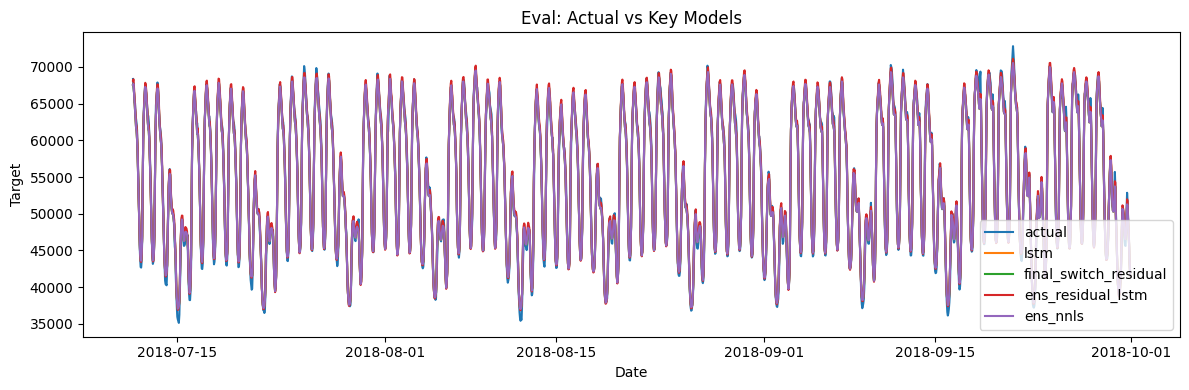

In [ ]:
key_models = ["lstm", "final_switch_residual", "ens_residual_lstm", "ens_nnls"]

# Full eval
plt.figure(figsize=(12,4))
plt.plot(eval_df["date"], y_eval, label="actual")
for m in key_models:
    plt.plot(eval_df["date"], preds_eval[m], label=m)
plt.title("Eval: Actual vs Key Models")
plt.xlabel("Date"); plt.ylabel("Target"); plt.legend()
plt.tight_layout()
plt.show()




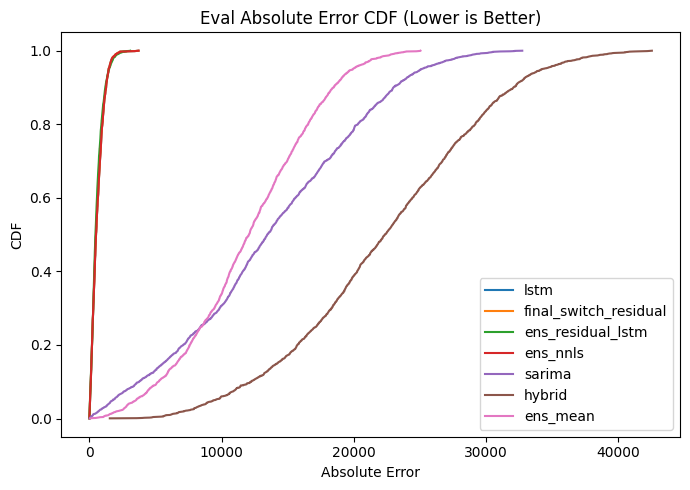

In [ ]:
plt.figure(figsize=(7,5))
for m in key_models + ["sarima", "hybrid", "ens_mean"]:
    ae = np.abs(y_eval - preds_eval[m])
    x = np.sort(ae)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, label=m)

plt.title("Eval Absolute Error CDF (Lower is Better)")
plt.xlabel("Absolute Error"); plt.ylabel("CDF"); plt.legend()
plt.tight_layout()
plt.show()


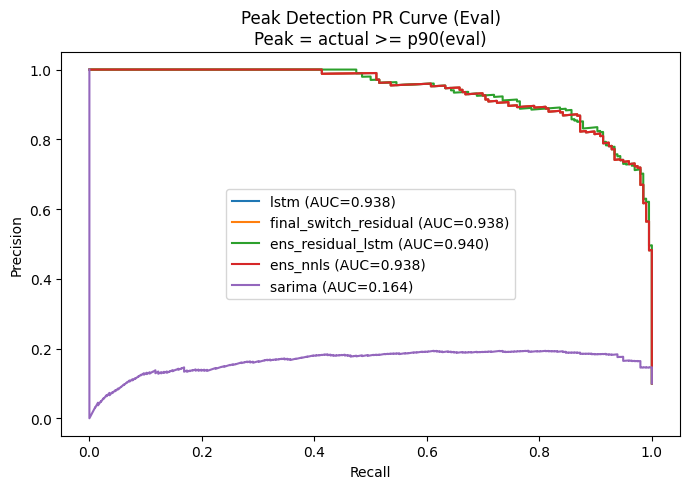

Saved: /content/sample_data/ensemble_outputs/peak_pr_summary.csv


,Model,PR_AUC,BestF1,BestThreshold
0,ens_residual_lstm,0.940493,0.870466,67211.284611
1,lstm,0.938314,0.870229,66590.540000
2,final_switch_residual,0.938314,0.870229,66590.540000
3,ens_nnls,0.938314,0.870229,66590.540000
4,sarima,0.164297,0.313093,44336.372276


In [ ]:
y_peak = is_peak_eval.astype(int)

plt.figure(figsize=(7,5))
pr_summary = []
for m in key_models + ["sarima"]:
    scores = preds_eval[m]  # score = predicted demand
    precision, recall, thresholds = precision_recall_curve(y_peak, scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{m} (AUC={pr_auc:.3f})")

    f1 = 2*precision*recall/(precision+recall+1e-12)
    best_idx = int(np.nanargmax(f1))
    best_f1 = float(f1[best_idx])
    best_thr = float(thresholds[best_idx-1]) if best_idx > 0 and best_idx-1 < len(thresholds) else np.nan

    pr_summary.append({"Model": m, "PR_AUC": pr_auc, "BestF1": best_f1, "BestThreshold": best_thr})

plt.title("Peak Detection PR Curve (Eval)\nPeak = actual >= p90(eval)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

pr_summary_df = pd.DataFrame(pr_summary).sort_values("PR_AUC", ascending=False).reset_index(drop=True)
pr_path = OUT_DIR / "peak_pr_summary.csv"
pr_summary_df.to_csv(pr_path, index=False)

print("Saved:", pr_path.resolve())
pr_summary_df


In [ ]:
switch_rate = float(np.mean(switch))
print("Switch rate:", switch_rate, "| triggered:", int(switch.sum()), "out of", len(eval_df))

def subset_report(mask, name):
    m = regression_metrics(y_eval[mask], preds_eval["final_switch_residual"][mask])
    return {"Subset": name, "N": int(mask.sum()), **m}

switch_diag = pd.DataFrame([
    subset_report(switch,  "SwitchTriggered=True"),
    subset_report(~switch, "SwitchTriggered=False")
])

diag_path = OUT_DIR / "switch_diagnostics.csv"
switch_diag.to_csv(diag_path, index=False)
print("Saved:", diag_path.resolve())

switch_diag


Switch rate: 0.0005104645227156713 | triggered: 1 out of 1959
Saved: /content/sample_data/ensemble_outputs/switch_diagnostics.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,Subset,N,MAE,RMSE,WAPE,sMAPE,R2,ME,MASE,DirectionalAccuracy,AE_P50,AE_P90,AE_P95
0,SwitchTriggered=True,1,1725.788585,1725.788585,0.023694,0.023978,NaN,1725.788585,NaN,NaN,1725.788585,1725.788585,1725.788585
1,SwitchTriggered=False,1958,607.962262,766.425754,0.011120,0.011453,0.993317,81.597226,0.327179,92.795095,502.162000,1260.067400,1459.627700


#Finding best Tuned switch

In [ ]:

qs = np.arange(0.80, 0.96, 0.01)
results = []

for q in qs:
    thr = np.quantile(y_train, q)

    # gate based on LSTM prediction
    sw = eval_df["lstm_pred"].values >= thr

    # switch: if gate true -> residual corrected; else -> plain lstm
    pred = np.where(sw, preds_eval["ens_residual_lstm"], preds_eval["lstm"])

    overall = regression_metrics(y_eval, pred)
    peak    = regression_metrics(y_eval[is_peak_eval], pred[is_peak_eval])

    results.append({
        "q": float(q),
        "thr": float(thr),
        "switch_rate": float(sw.mean()),
        "overall_MAE": float(overall["MAE"]),
        "peak_MAE": float(peak["MAE"]),
        "overall_AE_P90": float(overall["AE_P90"]),
        "peak_AE_P90": float(peak["AE_P90"]),
    })

tune_df = (
    pd.DataFrame(results)
    .sort_values(["peak_MAE", "overall_MAE", "switch_rate"], ascending=[True, True, True])
    .reset_index(drop=True)
)

# pick best q dynamically (top row after sorting)
BEST_Q = float(tune_df.loc[0, "q"])
thr    = float(tune_df.loc[0, "thr"])

# build final tuned model with best threshold
switch = eval_df["lstm_pred"].values >= thr
final_switch_tuned = np.where(switch, preds_eval["ens_residual_lstm"], preds_eval["lstm"])

# evaluate tuned model
overall = regression_metrics(y_eval, final_switch_tuned)
peak    = regression_metrics(y_eval[is_peak_eval], final_switch_tuned[is_peak_eval])

print("Chosen q:", BEST_Q, "| thr:", thr)
print("Switch rate:", float(switch.mean()), "| triggered:", int(switch.sum()), "out of", len(eval_df))
print("\nOverall:", overall)
print("\nPeak:", peak)


# OUT_DIR.mkdir(exist_ok=True, parents=True)
# tune_df.to_csv(OUT_DIR / "switch_threshold_tuning.csv", index=False)

tune_df.head(15)



Chosen q: 0.81 | thr: 68100.08
Switch rate: 0.026544155181214904 | triggered: 52 out of 1959

Overall: {'MAE': 606.220450943131, 'RMSE': 764.4861613905385, 'WAPE': np.float64(0.01108631904031208), 'sMAPE': np.float64(0.011426084331021701), 'R2': 0.9933596395824601, 'ME': 67.58380281518833, 'MASE': 0.3262065846343378, 'DirectionalAccuracy': 92.59448416751788, 'AE_P50': np.float64(499.8159999999989), 'AE_P90': np.float64(1251.6899999999953), 'AE_P95': np.float64(1457.1378999999977)}

Peak: {'MAE': 588.1768336611925, 'RMSE': 806.047183674195, 'WAPE': np.float64(0.008641805960669125), 'sMAPE': np.float64(0.00866655035698088), 'R2': 0.3978814516568371, 'ME': 317.62937609670377, 'MASE': 0.828687421435432, 'DirectionalAccuracy': 80.51282051282051, 'AE_P50': np.float64(442.32665614855796), 'AE_P90': np.float64(1139.9845852153594), 'AE_P95': np.float64(1541.9075000000012)}


,q,thr,switch_rate,overall_MAE,peak_MAE,overall_AE_P90,peak_AE_P90
0,0.81,68100.08,0.026544,606.220451,588.176834,1251.6900,1139.984585
1,0.82,68365.04,0.022971,606.583689,591.807365,1255.1420,1163.284584
2,0.83,68568.40,0.015314,607.013366,596.101935,1255.1420,1163.284584
3,0.80,67884.20,0.034712,607.785982,603.824152,1255.1420,1163.284584
4,0.85,69035.80,0.007147,608.143196,607.394478,1259.8756,1311.225000
5,0.86,69257.32,0.005105,608.361402,609.575416,1259.0200,1251.342500
6,0.88,69647.52,0.002552,608.382816,609.789450,1259.0200,1251.342500
7,0.89,69897.04,0.002552,608.382816,609.789450,1259.0200,1251.342500
8,0.90,70168.00,0.000510,608.532873,611.289253,1261.6220,1323.540000
9,0.91,70417.92,0.000510,608.532873,611.289253,1261.6220,1323.540000


In [ ]:
trigger_df = eval_df[["date","actual","lstm_pred"]].copy()
trigger_df["switch"] = switch
trigger_df["is_peak_eval"] = (eval_df["actual"].values >= p90_eval)

triggered = trigger_df[trigger_df["switch"]].copy()
print("Triggered count:", len(triggered))
print("Triggered & actually peak:", int(triggered["is_peak_eval"].sum()), "/", len(triggered))

triggered.sort_values("actual", ascending=False).head(15)


Triggered count: 52
Triggered & actually peak: 52 / 52


,date,actual,lstm_pred,switch,is_peak_eval
6297,2018-09-21 09:00:00+00:00,72836.0,70548.050,True,True
6298,2018-09-21 10:00:00+00:00,71712.0,70092.190,True,True
6296,2018-09-21 08:00:00+00:00,71652.0,70057.820,True,True
6299,2018-09-21 11:00:00+00:00,70505.0,68990.720,True,True
6295,2018-09-21 07:00:00+00:00,70327.0,69123.445,True,True
6057,2018-09-11 09:00:00+00:00,70270.0,69302.230,True,True
5697,2018-08-27 09:00:00+00:00,70175.0,68875.870,True,True
6369,2018-09-24 09:00:00+00:00,70132.0,69970.280,True,True
4905,2018-07-25 09:00:00+00:00,70121.0,68584.850,True,True
6058,2018-09-11 10:00:00+00:00,69996.0,69244.110,True,True


In [ ]:
# print("Triggered:", int(trigger_df["switch"].sum()))
# print("Triggered AND peak:", int((trigger_df["switch"] & trigger_df["is_peak_eval"]).sum()))
# print("Precision of gate (trigger => peak):",
#       float((trigger_df["switch"] & trigger_df["is_peak_eval"]).sum() / trigger_df["switch"].sum()))
# print("Recall of gate (peak caught by trigger):",
#       float((trigger_df["switch"] & trigger_df["is_peak_eval"]).sum() / trigger_df["is_peak_eval"].sum()))


In [ ]:
# ---------- Build one wide comparison table (EVAL only) ----------
comparison_df = eval_df[["date", "actual", "sarima_pred", "lstm_pred", "hybrid_pred"]].copy()


for name, pred in preds_eval.items():
    comparison_df[name] = pred


comparison_df["final_switch_tuned_q083"] = final_switch_tuned


comparison_df["is_peak_eval"] = (comparison_df["actual"].values >= np.quantile(comparison_df["actual"].values, 0.90))
comparison_df["switch_q083"] = switch


models_for_errors = [
    "sarima_pred", "lstm_pred", "hybrid_pred",
    "ens_mean", "ens_median", "ens_stack_ridge", "ens_weighted_ridge",
    "ens_nnls", "ens_residual_lstm", "final_switch_residual", "final_switch_tuned_q083"
]

for m in models_for_errors:
    if m in comparison_df.columns:
        comparison_df[f"AE_{m}"] = np.abs(comparison_df["actual"] - comparison_df[m])


out_path = OUT_DIR / "comparison_table_eval_all_models.csv"
comparison_df.to_csv(out_path, index=False)

print("Saved full comparison table to:", out_path.resolve())
comparison_df.head(10)


Saved full comparison table to: /content/sample_data/ensemble_outputs/comparison_table_eval_all_models.csv


,date,actual,sarima_pred,lstm_pred,hybrid_pred,sarima,lstm,hybrid,ens_mean,ens_median,...,AE_lstm_pred,AE_hybrid_pred,AE_ens_mean,AE_ens_median,AE_ens_stack_ridge,AE_ens_weighted_ridge,AE_ens_nnls,AE_ens_residual_lstm,AE_final_switch_residual,AE_final_switch_tuned_q083
4569,2018-07-11 09:00:00+00:00,68364.0,48367.255301,67579.530,41108.790079,48367.255301,67579.530,41108.790079,52351.858460,48367.255301,...,784.470,27255.209921,16012.141540,19996.744699,190.157515,205.747160,784.470,222.144474,784.470,784.470
4570,2018-07-11 10:00:00+00:00,67159.0,49801.122519,67697.336,42615.690329,49801.122519,67697.336,42615.690329,53371.382949,49801.122519,...,538.336,24543.309671,13787.617051,17357.877481,1519.389993,1075.714568,538.336,1161.452960,538.336,538.336
4571,2018-07-11 11:00:00+00:00,66476.0,49628.774859,66495.710,42902.543903,49628.774859,66495.710,42902.543903,53009.009587,49628.774859,...,19.710,23573.456097,13466.990413,16847.225141,919.225493,532.836000,19.710,605.826147,19.710,19.710
4572,2018-07-11 12:00:00+00:00,65167.0,48351.772772,65363.727,40940.707973,48351.772772,65363.727,40940.707973,51552.069248,48351.772772,...,196.727,24226.292027,13614.930752,16815.227228,1080.419708,694.151785,196.727,768.028688,196.727,196.727
4573,2018-07-11 13:00:00+00:00,65046.0,47313.966747,63887.664,39893.339617,47313.966747,63887.664,39893.339617,50364.990121,47313.966747,...,1158.336,25152.660383,14681.009879,17732.033253,344.447208,678.638129,1158.336,633.781283,1158.336,1158.336
4574,2018-07-11 14:00:00+00:00,63525.0,47173.216373,63078.176,39353.088851,47173.216373,63078.176,39353.088851,49868.160408,47173.216373,...,446.824,24171.911149,13656.839592,16351.783627,353.386262,1.500481,446.824,96.657199,446.824,446.824
4575,2018-07-11 15:00:00+00:00,62944.0,48808.544686,61726.434,41681.549924,48808.544686,61726.434,41681.549924,50738.842870,48808.544686,...,1217.566,21262.450076,12205.157130,14135.455314,512.513661,855.324051,1217.566,643.446968,1217.566,1217.566
4576,2018-07-11 16:00:00+00:00,62288.0,51329.809681,61240.540,43988.336941,51329.809681,61240.540,43988.336941,52186.228874,51329.809681,...,1047.460,18299.663059,10101.771126,10958.190319,342.315614,791.354196,1047.460,344.690131,1047.460,1047.460
4577,2018-07-11 17:00:00+00:00,61383.0,51047.299303,60044.848,43925.029073,51047.299303,60044.848,43925.029073,51672.392126,51047.299303,...,1338.152,17457.970927,9710.607874,10335.700697,700.694498,1108.829943,1338.152,662.181342,1338.152,1338.152
4578,2018-07-11 18:00:00+00:00,58445.0,49247.281980,58301.137,41710.394940,49247.281980,58301.137,41710.394940,49752.937973,49247.281980,...,143.863,16734.605060,8692.062027,9197.718020,432.502552,72.775787,143.863,476.283143,143.863,143.863


In [ ]:
cols_core = [
    "date", "actual", "lstm_pred",
    "ens_residual_lstm", "final_switch_tuned_q083",
    "switch_q083", "is_peak_eval",
    "AE_lstm_pred", "AE_ens_residual_lstm", "AE_final_switch_tuned_q083"
]

triggered_view = comparison_df[comparison_df["switch_q083"]][cols_core].sort_values("actual", ascending=False)

print("Triggered rows:", len(triggered_view))
triggered_view.head(30)


Triggered rows: 52


,date,actual,lstm_pred,ens_residual_lstm,final_switch_tuned_q083,switch_q083,is_peak_eval,AE_lstm_pred,AE_ens_residual_lstm,AE_final_switch_tuned_q083
6297,2018-09-21 09:00:00+00:00,72836.0,70548.050,71110.211415,71110.211415,True,True,2287.950,1725.788585,1725.788585
6298,2018-09-21 10:00:00+00:00,71712.0,70092.190,70765.632902,70765.632902,True,True,1619.810,946.367098,946.367098
6296,2018-09-21 08:00:00+00:00,71652.0,70057.820,70542.623157,70542.623157,True,True,1594.180,1109.376843,1109.376843
6299,2018-09-21 11:00:00+00:00,70505.0,68990.720,69632.544580,69632.544580,True,True,1514.280,872.455420,872.455420
6295,2018-09-21 07:00:00+00:00,70327.0,69123.445,69506.126570,69506.126570,True,True,1203.555,820.873430,820.873430
6057,2018-09-11 09:00:00+00:00,70270.0,69302.230,69854.663910,69854.663910,True,True,967.770,415.336090,415.336090
5697,2018-08-27 09:00:00+00:00,70175.0,68875.870,69422.068209,69422.068209,True,True,1299.130,752.931791,752.931791
6369,2018-09-24 09:00:00+00:00,70132.0,69970.280,70537.679946,70537.679946,True,True,161.720,405.679946,405.679946
4905,2018-07-25 09:00:00+00:00,70121.0,68584.850,69146.265441,69146.265441,True,True,1536.150,974.734559,974.734559
6058,2018-09-11 10:00:00+00:00,69996.0,69244.110,69899.946673,69899.946673,True,True,751.890,96.053327,96.053327


In [ ]:
top_peaks_view = comparison_df[comparison_df["is_peak_eval"]].sort_values("actual", ascending=False)[cols_core]
top_peaks_view.head(30)


,date,actual,lstm_pred,ens_residual_lstm,final_switch_tuned_q083,switch_q083,is_peak_eval,AE_lstm_pred,AE_ens_residual_lstm,AE_final_switch_tuned_q083
6297,2018-09-21 09:00:00+00:00,72836.0,70548.050,71110.211415,71110.211415,True,True,2287.950,1725.788585,1725.788585
6298,2018-09-21 10:00:00+00:00,71712.0,70092.190,70765.632902,70765.632902,True,True,1619.810,946.367098,946.367098
6296,2018-09-21 08:00:00+00:00,71652.0,70057.820,70542.623157,70542.623157,True,True,1594.180,1109.376843,1109.376843
6299,2018-09-21 11:00:00+00:00,70505.0,68990.720,69632.544580,69632.544580,True,True,1514.280,872.455420,872.455420
6295,2018-09-21 07:00:00+00:00,70327.0,69123.445,69506.126570,69506.126570,True,True,1203.555,820.873430,820.873430
6057,2018-09-11 09:00:00+00:00,70270.0,69302.230,69854.663910,69854.663910,True,True,967.770,415.336090,415.336090
5697,2018-08-27 09:00:00+00:00,70175.0,68875.870,69422.068209,69422.068209,True,True,1299.130,752.931791,752.931791
6369,2018-09-24 09:00:00+00:00,70132.0,69970.280,70537.679946,70537.679946,True,True,161.720,405.679946,405.679946
4905,2018-07-25 09:00:00+00:00,70121.0,68584.850,69146.265441,69146.265441,True,True,1536.150,974.734559,974.734559
6058,2018-09-11 10:00:00+00:00,69996.0,69244.110,69899.946673,69899.946673,True,True,751.890,96.053327,96.053327


In [ ]:
def summarize_model(actual, pred, name):
    m = regression_metrics(actual, pred)
    return {
        "Model": name,
        "MAE": m["MAE"],
        "RMSE": m["RMSE"],
        "WAPE": m["WAPE"],
        "sMAPE": m["sMAPE"],
        "R2": m["R2"],
        "AE_P90": m["AE_P90"],
        "AE_P95": m["AE_P95"]
    }

actual = comparison_df["actual"].values

summary_rows = []
for col in ["sarima_pred", "lstm_pred", "hybrid_pred",
            "ens_mean", "ens_median", "ens_stack_ridge", "ens_weighted_ridge",
            "ens_nnls", "ens_residual_lstm", "final_switch_residual", "final_switch_tuned_q083"]:
    if col in comparison_df.columns:
        summary_rows.append(summarize_model(actual, comparison_df[col].values, col))

summary_table = pd.DataFrame(summary_rows).sort_values("MAE").reset_index(drop=True)
summary_table

# Save to CSV
out_path = OUT_DIR / "models_summary_table.csv"
summary_table.to_csv(out_path, index=False)

print("Saved full comparison table to:", out_path.resolve())
summary_table.head(11)

Saved full comparison table to: /content/sample_data/ensemble_outputs/models_summary_table.csv


,Model,MAE,RMSE,WAPE,sMAPE,R2,AE_P90,AE_P95
0,ens_residual_lstm,577.085900,740.699466,0.010554,0.010963,0.993766,1202.095775,1489.572575
1,final_switch_tuned_q083,606.220451,764.486161,0.011086,0.011426,0.993360,1251.690000,1457.137900
2,final_switch_residual,608.532873,767.221562,0.011129,0.011460,0.993312,1261.622000,1461.339200
3,lstm_pred,608.819836,767.971824,0.011134,0.011464,0.993299,1261.622000,1461.339200
4,ens_nnls,608.819836,767.971824,0.011134,0.011464,0.993299,1261.622000,1461.339200
5,ens_stack_ridge,634.428527,810.886778,0.011602,0.011668,0.992529,1317.787372,1631.751675
6,ens_weighted_ridge,640.731678,810.494287,0.011717,0.012130,0.992536,1314.214948,1601.425204
7,ens_mean,12018.708847,13002.103258,0.219793,0.244729,-0.920789,18477.304756,19924.817700
8,ens_median,13684.004690,15436.622719,0.250248,0.283225,-1.707428,22996.444564,25094.573283
9,sarima_pred,13704.826955,15438.484198,0.250628,0.283652,-1.708081,22996.444564,25094.573283


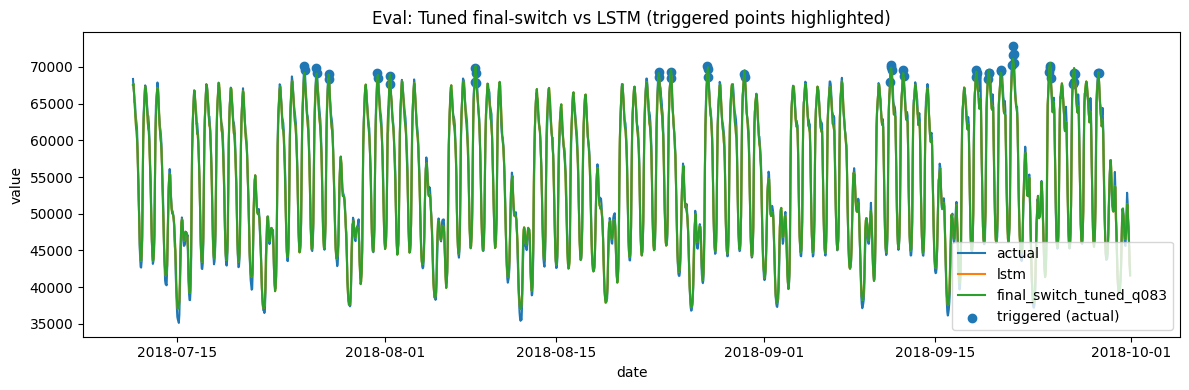

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(comparison_df["date"], comparison_df["actual"], label="actual")
plt.plot(comparison_df["date"], comparison_df["lstm_pred"], label="lstm")
plt.plot(comparison_df["date"], comparison_df["final_switch_tuned_q083"], label="final_switch_tuned_q083")

# highlight triggered points
tr = comparison_df["switch_q083"].values
plt.scatter(comparison_df["date"][tr], comparison_df["actual"][tr], label="triggered (actual)", marker="o")
plt.title("Eval: Tuned final-switch vs LSTM (triggered points highlighted)")
plt.xlabel("date"); plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.show()


,Model,OVERALL_MAE,PEAK_MAE
8,ens_residual_lstm,577.085900,529.915300
10,final_switch_tuned_q083,606.220451,588.176834
9,final_switch_residual,608.532873,611.289253
0,lstm_pred,608.819836,614.157423
7,ens_nnls,608.819836,614.157424
5,ens_stack_ridge,634.428527,757.783890
6,ens_weighted_ridge,640.731678,534.738783
3,ens_mean,12018.708847,17721.648095
4,ens_median,13684.004690,21935.810765
1,sarima_pred,13704.826955,21935.810765


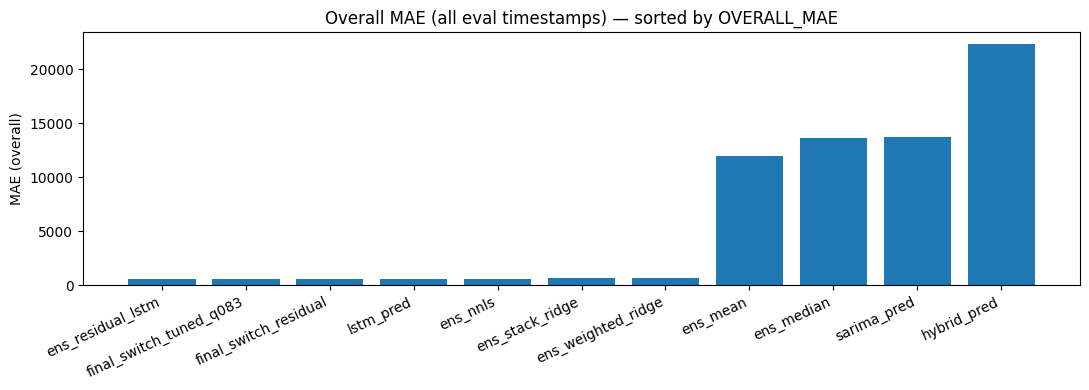

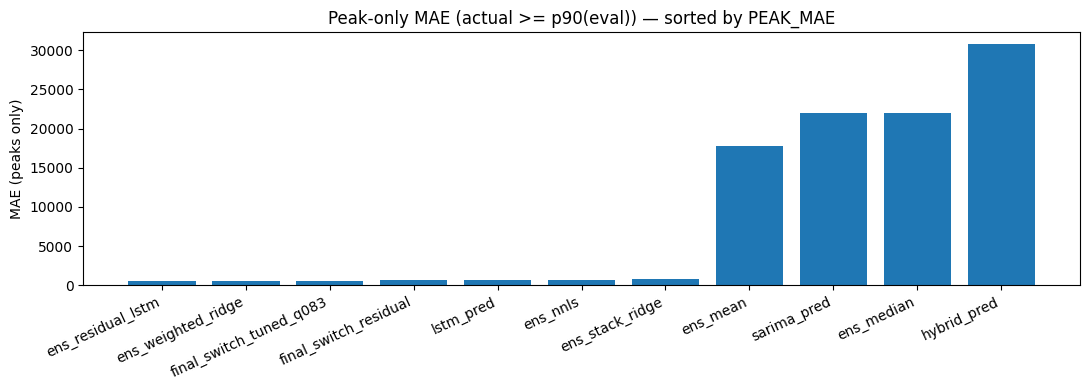

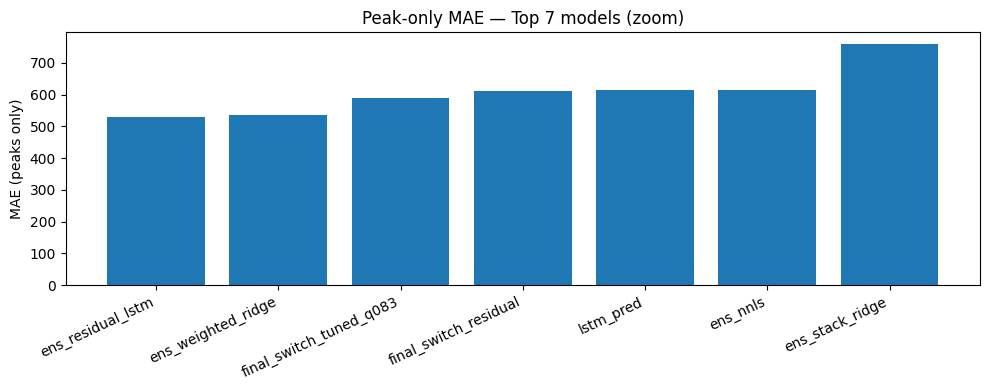

Best OVERALL: ens_residual_lstm | OVERALL_MAE: 577.0859002434432 | PEAK_MAE: 529.9153002470929
Best PEAK:    ens_residual_lstm | OVERALL_MAE: 577.0859002434432 | PEAK_MAE: 529.9153002470929


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1) model list
models = [
    "lstm_pred", "sarima_pred", "hybrid_pred",
    "ens_mean", "ens_median",
    "ens_stack_ridge", "ens_weighted_ridge",
    "ens_nnls",
    "ens_residual_lstm",
    "final_switch_residual",
    "final_switch_tuned_q083"
]
models = [m for m in models if m in comparison_df.columns]

# 2) peak subset
peak_df = comparison_df[comparison_df["is_peak_eval"].astype(bool)].copy()

# 3) compute MAEs
overall_mae = {m: mean_absolute_error(comparison_df["actual"], comparison_df[m]) for m in models}
peak_mae    = {m: mean_absolute_error(peak_df["actual"], peak_df[m]) for m in models}

comp_tbl = pd.DataFrame({
    "Model": models,
    "OVERALL_MAE": [overall_mae[m] for m in models],
    "PEAK_MAE":    [peak_mae[m] for m in models],
}).reset_index(drop=True)

display(comp_tbl.sort_values("OVERALL_MAE"))

# --------------------------
# Plot A: OVERALL
# --------------------------
comp_overall = comp_tbl.sort_values("OVERALL_MAE", ascending=True).reset_index(drop=True)
plt.figure(figsize=(11,4))
plt.bar(comp_overall["Model"], comp_overall["OVERALL_MAE"])
plt.title("Overall MAE (all eval timestamps) — sorted by OVERALL_MAE")
plt.ylabel("MAE (overall)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# --------------------------
# Plot B: PEAK-only
# --------------------------
comp_peak = comp_tbl.sort_values("PEAK_MAE", ascending=True).reset_index(drop=True)
plt.figure(figsize=(11,4))
plt.bar(comp_peak["Model"], comp_peak["PEAK_MAE"])
plt.title("Peak-only MAE (actual >= p90(eval)) — sorted by PEAK_MAE")
plt.ylabel("MAE (peaks only)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# --------------------------
# Optional: Zoomed peak plot
# --------------------------
topk = 7
comp_peak_top = comp_peak.head(topk)
plt.figure(figsize=(10,4))
plt.bar(comp_peak_top["Model"], comp_peak_top["PEAK_MAE"])
plt.title(f"Peak-only MAE — Top {topk} models (zoom)")
plt.ylabel("MAE (peaks only)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# 5) Print best models explicitly
best_overall = comp_tbl.loc[comp_tbl["OVERALL_MAE"].idxmin()]
best_peak    = comp_tbl.loc[comp_tbl["PEAK_MAE"].idxmin()]

print("Best OVERALL:", best_overall["Model"], "| OVERALL_MAE:", best_overall["OVERALL_MAE"], "| PEAK_MAE:", best_overall["PEAK_MAE"])
print("Best PEAK:   ", best_peak["Model"],    "| OVERALL_MAE:", best_peak["OVERALL_MAE"],    "| PEAK_MAE:", best_peak["PEAK_MAE"])




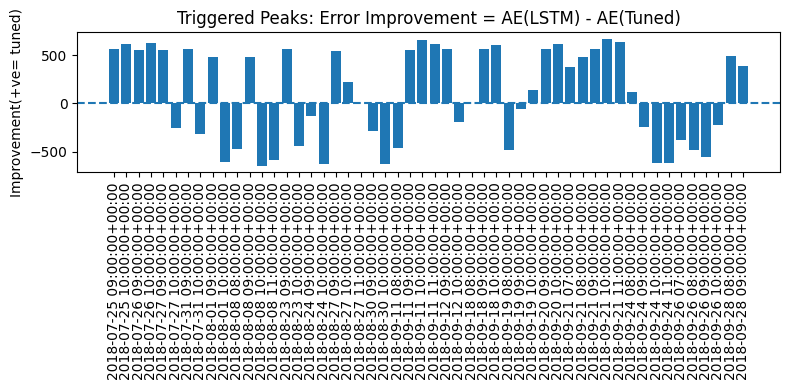

Triggered events improved count: 30 / 52
Mean improvement: 97.92683850781283


In [ ]:
trig = comparison_df[comparison_df["switch_q083"]].copy()
delta = trig["AE_lstm_pred"] - trig["AE_final_switch_tuned_q083"]

plt.figure(figsize=(8,4))
plt.bar(trig["date"].astype(str), delta)
plt.axhline(0, linestyle="--")
plt.title("Triggered Peaks: Error Improvement = AE(LSTM) - AE(Tuned)")
plt.ylabel("Improvement(+ve= tuned)")
plt.xticks(rotation=90)
plt.tight_layout(); plt.show()

print("Triggered events improved count:", int((delta > 0).sum()), "/", len(delta))
print("Mean improvement:", float(delta.mean()))


NNLS weights: [0. 1. 0.]


/tmp/ipython-input-2488058732.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_mean.values, X_eval_base, feature_names=feature_names, show=False)


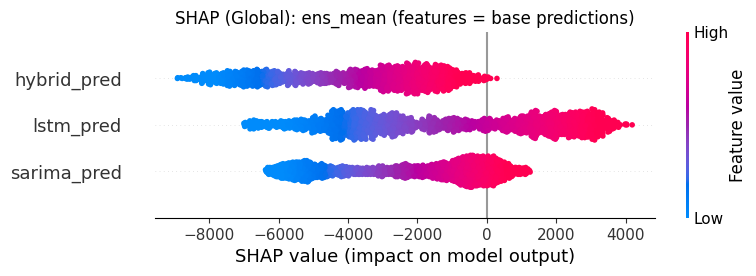

/tmp/ipython-input-2488058732.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_nnls.values, X_eval_base, feature_names=feature_names, show=False)


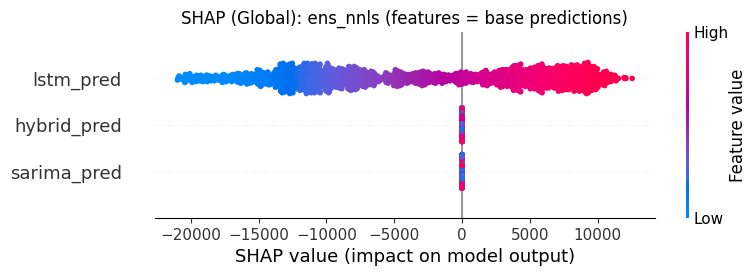

/tmp/ipython-input-2488058732.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_wridge.values, X_eval_base, feature_names=feature_names, show=False)


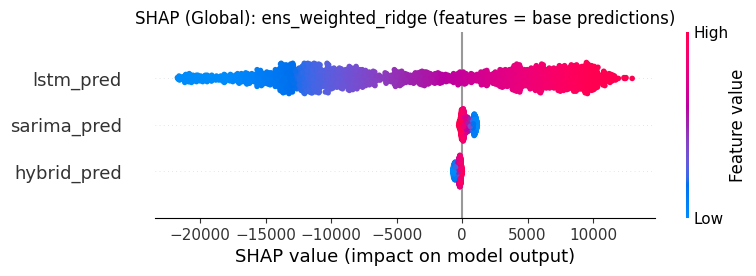

/tmp/ipython-input-2488058732.py:61: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_stack.values, Xev_scaled, feature_names=feature_names, show=False)


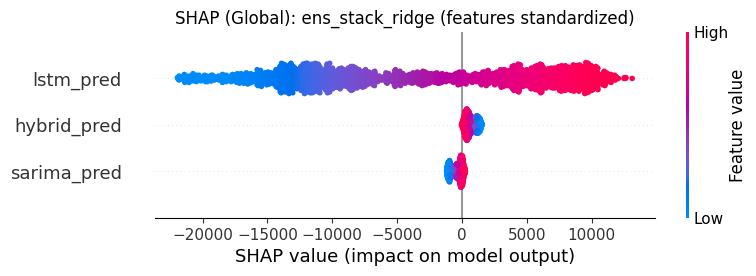

In [ ]:
# ==============================
# XAI : SHAP for meta/linear ensembles
# ==============================

import shap
from scipy.optimize import nnls

feature_names = ["sarima_pred", "lstm_pred", "hybrid_pred"]

X_train_base = train_df[feature_names].values
y_train_base = train_df["actual"].values
X_eval_base  = eval_df[feature_names].values

class FixedLinearModel:
    """Simple linear predictor: y = X @ w + b"""
    def __init__(self, w, b=0.0):
        self.coef_ = np.asarray(w, dtype=float)
        self.intercept_ = float(b)
    def predict(self, X):
        return X @ self.coef_ + self.intercept_

# Mean weights
mean_model = FixedLinearModel([1/3, 1/3, 1/3], b=0.0)

# NNLS weights
w_raw, _ = nnls(X_train_base, y_train_base)
w = w_raw / (w_raw.sum() + 1e-12)
nnls_model = FixedLinearModel(w, b=0.0)

print("NNLS weights:", w)

# ---- SHAP: ens_mean ----
expl_mean = shap.LinearExplainer(mean_model, X_train_base, feature_names=feature_names)
shap_mean = expl_mean(X_eval_base)
shap.summary_plot(shap_mean.values, X_eval_base, feature_names=feature_names, show=False)
plt.title("SHAP (Global): ens_mean (features = base predictions)")
plt.show()

# ---- SHAP: ens_nnls ----
expl_nnls = shap.LinearExplainer(nnls_model, X_train_base, feature_names=feature_names)
shap_nnls = expl_nnls(X_eval_base)
shap.summary_plot(shap_nnls.values, X_eval_base, feature_names=feature_names, show=False)
plt.title("SHAP (Global): ens_nnls (features = base predictions)")
plt.show()

# ---- SHAP: ens_weighted_ridge ----

expl_wridge = shap.LinearExplainer(ens_weighted_ridge, X_train_base, feature_names=feature_names)
shap_wridge = expl_wridge(X_eval_base)
shap.summary_plot(shap_wridge.values, X_eval_base, feature_names=feature_names, show=False)
plt.title("SHAP (Global): ens_weighted_ridge (features = base predictions)")
plt.show()

# ---- SHAP: ens_stack_ridge ----
Xtr_scaled = ens_stack_ridge.named_steps["scaler"].transform(X_train_base)
Xev_scaled = ens_stack_ridge.named_steps["scaler"].transform(X_eval_base)
ridge_stack = ens_stack_ridge.named_steps["ridge"]

expl_stack = shap.LinearExplainer(ridge_stack, Xtr_scaled, feature_names=feature_names)
shap_stack = expl_stack(Xev_scaled)
shap.summary_plot(shap_stack.values, Xev_scaled, feature_names=feature_names, show=False)
plt.title("SHAP (Global): ens_stack_ridge (features standardized)")
plt.show()


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipython-input-884554881.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_median, X_sample, feature_names=feature_names, show=False)


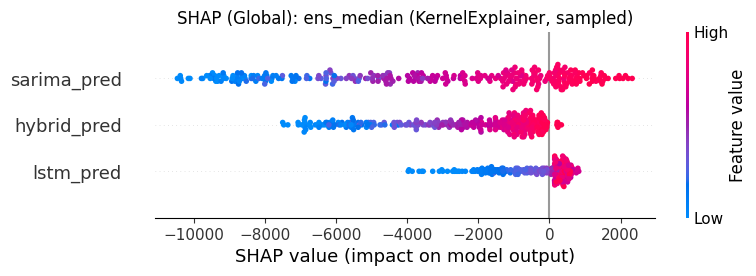

In [ ]:
# ==============================
# XAI : SHAP for ens_median (model-agnostic)
# Median is non-linear; use KernelExplainer with sampling.
# ==============================

def median_predict(X):

    return np.median(X, axis=1)


bg = shap.sample(X_train_base, 200, random_state=RANDOM_SEED)
X_sample = shap.sample(X_eval_base, 300, random_state=RANDOM_SEED)

expl_median = shap.KernelExplainer(median_predict, bg)
shap_median = expl_median.shap_values(X_sample, nsamples=200)

# Summary plot
shap.summary_plot(shap_median, X_sample, feature_names=feature_names, show=False)
plt.title("SHAP (Global): ens_median (KernelExplainer, sampled)")
plt.show()


Residual model feature count: 2
Residual model features: ['sarima_pred', 'hybrid_pred']


/tmp/ipython-input-3724160882.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


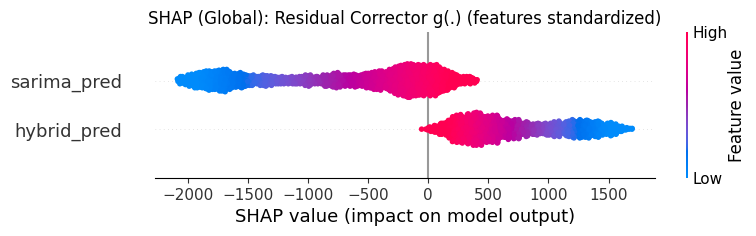

Max actual time: 2018-09-21 09:00:00+00:00 | actual: 72836.0


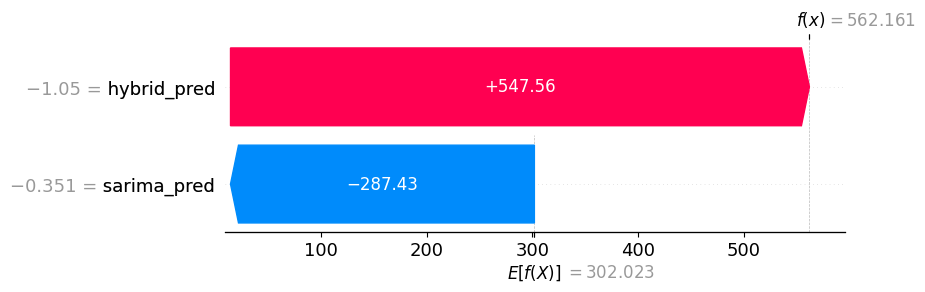


Predicted residual correction g(x) at this point: 562.1614148022736
Final ensemble at this point = lstm_pred + g(x)
lstm_pred: 70548.05
ens_residual_lstm: 71110.21141480228


In [ ]:
import shap


res_feat_names = ["sarima_pred", "hybrid_pred"]


scaler = res_model.named_steps["scaler"]
ridge_res = res_model.named_steps["ridge"]

Xr_tr_scaled = scaler.transform(Xr_train)
Xr_ev_scaled = scaler.transform(Xr_eval)

print("Residual model feature count:", Xr_train.shape[1])
print("Residual model features:", res_feat_names)

expl_res = shap.LinearExplainer(ridge_res, Xr_tr_scaled, feature_names=res_feat_names)
shap_res = expl_res(Xr_ev_scaled)

shap.summary_plot(
    shap_res.values,
    Xr_ev_scaled,
    feature_names=res_feat_names,
    show=False
)
plt.title("SHAP (Global): Residual Corrector g(.) (features standardized)")
plt.show()

imax = int(np.argmax(y_eval))
print("Max actual time:", eval_df.iloc[imax]["date"], "| actual:", float(y_eval[imax]))

exp_one = shap.Explanation(
    values=shap_res.values[imax],
    base_values=shap_res.base_values[imax] if np.ndim(shap_res.base_values) else shap_res.base_values,
    data=Xr_ev_scaled[imax],
    feature_names=res_feat_names
)
shap.plots.waterfall(exp_one, max_display=10)


fx = float(exp_one.base_values + np.sum(exp_one.values))
print("\nPredicted residual correction g(x) at this point:", fx)
print("Final ensemble at this point = lstm_pred + g(x)")
print("lstm_pred:", float(eval_df.iloc[imax]["lstm_pred"]))
print("ens_residual_lstm:", float(eval_df.iloc[imax]["lstm_pred"] + fx))